In [ ]:
"""
Author: Yang Hu
1. This file gives a script to constrain cosmological parameters (H0, Omega0, Omegak, M, etc.) in a parametric model
using 3 probes: strong gravitational lenses (Lens), type Ia supernovae (SNe Ia) and baryon accoustic oscillation
(BAO).
2. For Lens, we use simulated LSST data. For SNe Ia, we use simulated Roman data. For BAO, we use simulated DESI data.
3. Constraints on parameters are obtained via Markov Chain Monte Carlo (MCMC) using emcee package.
4. A model of mock universe has to be chosen before doing the analysis.
"""

In [1]:
"""
standard imports for data analysis and astropy.cosmology to compute astrophysical quantities with ease
"""

import numpy as np
import pandas as pd
import emcee
import corner
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from astropy.cosmology import FlatwCDM, LambdaCDM, wCDM

In [2]:
"""
Load source data.
"""

#load and rename Lens data
use_lens = 'Goldstein2019' # choose between Goldstein2019, Uniform or Arendse2023
real_number = 1000 # equivalent number of lenses involved

if use_lens == 'Goldstein2019':
    data1 = pd.read_csv("../data/zlens_zsource_310LSSTLike_20.csv",skiprows=1,header=None) # Goldstein et al. (2019)
    zlens = np.array(data1[0])
    zsource = np.array(data1[1])
    ddt_err = np.array(data1[2])*np.sqrt(310/1000) # To estimate the uncertainty for 1000 lenses, we apply a factor of sqrt(N).
elif use_lens == 'Uniform':
    data1 = pd.read_csv("../data/uniform_1000LSSTLike_20.csv",skiprows=1,header=None)
    zlens = np.array(data1[0])
    zsource = np.array(data1[1])
    ddt_err = np.array(data1[2])
elif use_lens == 'Arendse2023':
    data1 = pd.read_csv("../data/Arendse23_redshifts_20.csv",skiprows=1,header=None) # Goldstein et al. (2019)
    zlens = np.array(data1[1])
    zsource = np.array(data1[0])
    ddt_err = np.array(data1[2])
else:
    print('Lens not defined')


#load and rename SNe data
data2 = pd.read_csv("../data/lcparam_WFIRST_G10.txt", delimiter=' ', skiprows=1, header=None)
data3 = pd.read_csv("../data/syscov_WFIRST.txt", delimiter=' ', skiprows=0, header=None)
zcmb = data2[1]

#for a measure of the uncertainty of SNe measurement, we need the covariance matrix in the following way
m_err = data2[5]
sys_err = np.array(data3)
D_stat = np.diag(m_err**2)
C_sys = sys_err.reshape((len(data2), len(data2)))
C = D_stat + C_sys
C_inv = np.linalg.inv(C)

#load and rename BAO data
data4 = pd.read_csv("../data/DESI_HZ_error.txt", delimiter=' ', skiprows=1, header=None) 
zBAO = data4[0]
sigHz = data4[1]

In [3]:
"""
We need to choose a mock universe model to generate the "true value" of cosmological parameters. They are
used to compute the log likelihood.
"""
#set cosmology here. So far, only owCDM model is available.
cosmology = "owCDM"

#set mock cosmology
#common parameters of interest are Hubble's constant H0, matter density Om0, curvature density Ok0,
#equation of state parameter w and absolute magnitude M.
if cosmology == "owCDM":
    H0_mock, Om0_mock, Ok0_mock, w_mock, M_mock = 72, 0.3, 0.00, -1, -19.2
    cosmo_mock = wCDM(H0=H0_mock, Om0=Om0_mock, Ode0=1.-Om0_mock-Ok0_mock, w0=w_mock)
else:
    print("Cosmology not defined.")

#compute mock time-delay distance for lenses
dd_mock = cosmo_mock.angular_diameter_distance(z=zlens)
ds_mock = cosmo_mock.angular_diameter_distance(z=zsource)
dds_mock = cosmo_mock.angular_diameter_distance_z1z2(z1=zlens, z2=zsource)
ddt_mock = (1. + zlens) * dd_mock * ds_mock / dds_mock

#compute mock luminosity distance for SNe
dl_mock = cosmo_mock.luminosity_distance(z=zcmb)
m_mock = 5*np.log10(np.array(dl_mock))+25+M_mock

#compute mock Hz from BAO data
Hz_mock = cosmo_mock.H(z=zBAO)

In [4]:
"""
Run this cell for owCDM Universe.
This cell defines the loss function of MCMC.
Constraints are obtained by MCMC and here we define the relevant prior and likelihood functions.
Note that if SNe Ia are included, there is an additional parameter of M.
"""

use_Lens = True
use_SNe = False
use_BAO = False

max_likelihood_test = True

#use uniform priors for all parameters
def log_prior(theta):
    """
    theta: list of floats, folded cosmological parameters.
    """
    if use_SNe:
        h0, om, ok, w, M = theta
        if 0. <= h0 <= 150. and 0. <= om <= 0.6 and -2. <= ok <= 2. and -2. <= w <= 0. and -25. <= M <= -15.:
            return 0.0
        else:
            return -np.inf
    else:
        h0, om, ok, w = theta
        if 0. <= h0 <= 150. and 0. <= om <= 0.6 and -2. <= ok <= 2. and -2. <= w <= 0.:
            return 0.0
        else:
            return -np.inf

#use a chi-square likelihood function
def log_likelihood(theta, zlens, zsource, ddt_err, zcmb, C_inv, zBAO, sigHz):
    """
    theta: list of floats, folded cosmological parameters.
    zlens: array of z at lens
    zsource: array of z at source
    ddt_err: array of uncertainty of time-delay distance
    zcmb: array of z of cmb, obtained for SNe data
    C_inv: covariance matrix indicating uncertainty of SNe data
    zBAO: array of z from BAO
    sigHz: array of uncertainty of Hz
    """
    if use_SNe:
        h0, om, ok, w, M = theta
    else:
        h0, om, ok, w = theta
    #check parameters are physical
    if (om < 0 or om > 1 or 1.-om-ok < 0 or 1.-om-ok > 1.
        or np.any(ok*(1.0+zsource)**2 + om*(1.0+zsource)**3 + (1.0-om-ok)*(1.0+zsource)**(3*(1+w)) <= 0)
        or np.any(ok*(1.0+zcmb)**2 + om*(1.0+zcmb)**3 + (1.0-om-ok)*(1.0+zcmb)**(3*(1+w)) <= 0)
       ):
        return -np.inf
    cosmo = wCDM(H0=h0, Om0=om, Ode0=1.0-om-ok, w0=w)
    chi_sq = 0
    ##compute chi_square for lenses
    if use_Lens:
        dd = cosmo.angular_diameter_distance(z=zlens)
        ds = cosmo.angular_diameter_distance(z=zsource)
        dds = cosmo.angular_diameter_distance_z1z2(z1=zlens, z2=zsource)
        ddt = (1. + zlens) * dd * ds / dds
        chi_sq += np.sum((ddt-ddt_mock)**2./(ddt*ddt_err)**2.)
    #compute chi_square for SNe
    if use_SNe:
        dl = cosmo.luminosity_distance(z=zcmb)
        m_model = 5*np.log10(np.array(dl))+25+M
        del_m = m_mock - m_model
        chi_sq += np.dot(del_m.T, np.dot(C_inv, del_m))
    #compute chi_square for BAO
    if use_BAO:
        Hz = cosmo.H(z=zBAO)
        chi_sq += np.sum((Hz-Hz_mock)**2./sigHz**2.)
    return -0.5*chi_sq

def log_probability(theta, zlens, zsource, ddt_err, zcmb, C_inv, zBAO, sigHz):
    """
    theta: list of floats, folded cosmological parameters.
    zlens: array of z at lens
    zsource: array of z at source
    ddt_err: array of uncertainty of time-delay distance
    zcmb: array of z of cmb, obtained for SNe data
    C_inv: covariance matrix indicating uncertainty of SNe data
    zBAO: array of z from BAO data
    sigHz: array of uncertainty of Hz
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, zlens, zsource, ddt_err, zcmb, C_inv, zBAO, sigHz)

"""
Naming
"""
name = ''
if use_Lens:
    if use_lens =='Goldstein2019':
        name += 'LSST'
    elif use_lens =='Uniform':
        name += 'LSSTu'
    else:
        name += 'LSSTa'
if use_SNe:
    if name == '':
        name += 'Roman'
    else:
        name += '+Roman'
if use_BAO:
    if name == '':
        name += 'DESI'
    else:
        name += '+DESI'
    
"""
Maximum likelihood test
"""
if max_likelihood_test:
    nll = lambda *args: -log_likelihood(*args)
    if use_SNe:
        initial = np.array([70., 0.27, 0.02, -1.1, -19.])
        soln = minimize(nll, initial, args=(zlens, zsource, ddt_err, zcmb, C_inv, zBAO, sigHz))
        H0_ml, Om_ml, Ok_ml, w_ml, M_ml = soln.x
        print("Maximum likelihood estimates (%s):" % name)
        print("H0_ml = {0:.3f}".format(H0_ml))
        print("Om_ml = {0:.3f}".format(Om_ml))
        print("Ok_ml = {0:.3f}".format(Ok_ml))
        print("w_ml = {0:.3f}".format(w_ml))
        print("M_ml = {0:.3f}".format(M_ml))
    else:
        initial = np.array([70., 0.27, 0.02, -1.1])
        soln = minimize(nll, initial, args=(zlens, zsource, ddt_err, zcmb, C_inv, zBAO, sigHz))
        H0_ml, Om_ml, Ok_ml, w_ml = soln.x
        print("Maximum likelihood estimates (%s):" % name)
        print("H0_ml = {0:.3f}".format(H0_ml))
        print("Om_ml = {0:.3f}".format(Om_ml))
        print("Ok_ml = {0:.3f}".format(Ok_ml))
        print("w_ml = {0:.3f}".format(w_ml))


C:\Users\12144\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\12144\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\12144\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\12144\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Maximum likelihood estimates (LSST):
H0_ml = 70.986
Om_ml = 0.007
Ok_ml = 0.193
w_ml = 0.124


In [5]:
"""
presettings for MCMC
"""
nwalkers = 32
nsamples = 8000
if use_SNe:
    startpos = [70., 0.27, 0.02, -1.1, -19.]  # H0, Om, Ok, w, M
    labels = ["$H_0$", "$\Omega_{m}$", "$\Omega_{K}$", "$w$", "$M$"]
    parameters = [H0_mock, Om0_mock, Ok0_mock, w_mock, M_mock]
else:
    startpos = [70., 0.27, 0.02, -1.1]  # H0, Om, Ok, w
    labels = ["$H_0$", "$\Omega_{m}$", "$\Omega_{K}$", "$w$"]
    parameters = [H0_mock, Om0_mock, Ok0_mock, w_mock]

'Plot not saved'

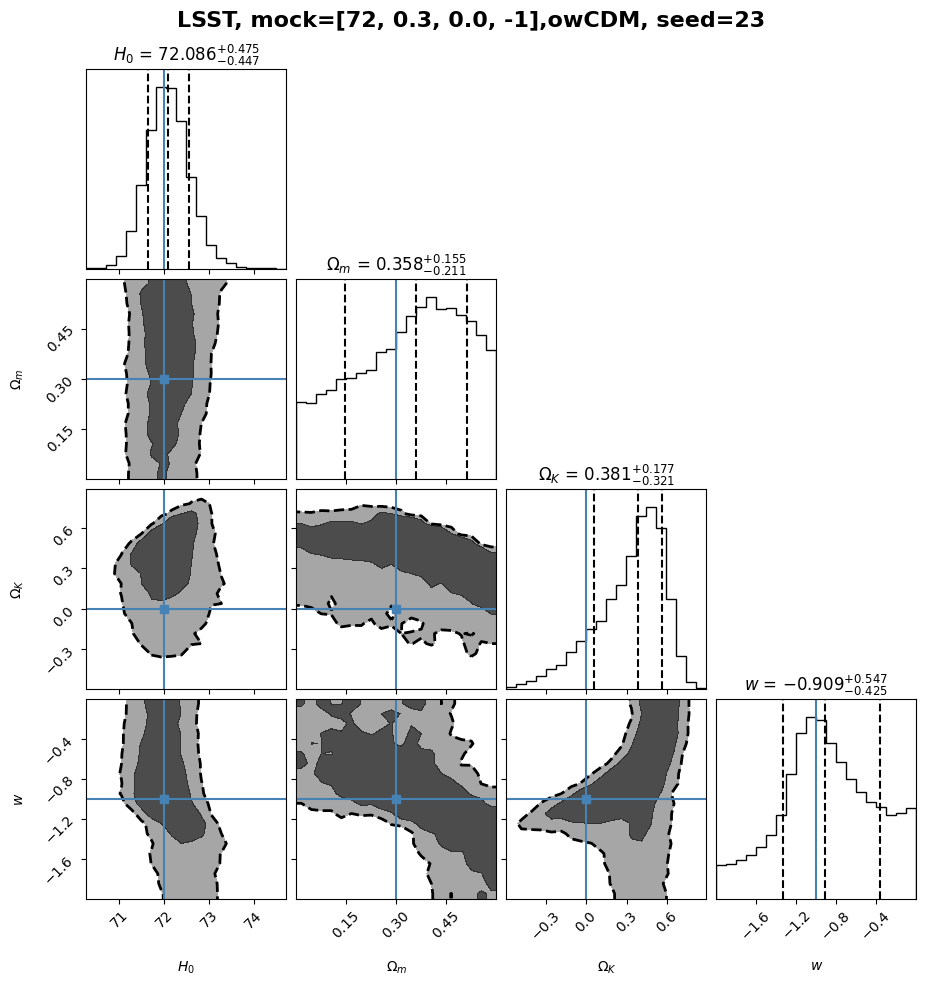

In [6]:
"""
MCMC
"""
#MCMC
run_MCMC = False
save_MCMC = False
plot_MCMC = True
save_plot_MCMC = False
mag_scattering = True

if use_SNe:
    seeds = [22,23,24] #this defines the seeds used for intrinsic scattering of absolute calibration for SNe Ia
else:
    seeds = [23]
    
for seed in seeds:
    np.random.seed(seed)
    
    #add in intrinsic scattering for SNe
    if mag_scattering:
        m_mock = 5*np.log10(np.array(dl_mock))+25+M_mock+np.random.normal(0, 0.02, size=len(zcmb))
    else:
        m_mock = 5*np.log10(np.array(dl_mock))+25+M_mock

    #run MCMC
    if run_MCMC:
        pos = startpos + 1e-4 * np.random.randn(nwalkers, len(startpos))
        nwalkers, ndim = pos.shape
        display("Sampling cosmological parameters in %s with %s for seed %s..." % (cosmology, name, seed))
        sampler = emcee.EnsembleSampler(
          nwalkers, ndim, log_probability, args=[zlens, zsource, ddt_err, zcmb, C_inv, zBAO, sigHz]
        )
        sampler.run_mcmc(pos, nsamples, progress=True);

    #save data
    if save_MCMC:
        samples = sampler.get_chain()
        flat_samples = sampler.get_chain(discard=500, thin=4, flat=True) #burn-in
        sample_data = pd.DataFrame(flat_samples)
        sample_data.to_csv(
            "../sample/%s_%s_%ix%i_%s.csv"
            % (name, cosmology, nwalkers, nsamples, seed),
            index=False, header=labels)

    #read data
    if plot_MCMC:
        flat_samples = pd.read_csv("../sample/%s_%s_%ix%i_%s.csv"
                                % (name,
                                    cosmology, nwalkers, nsamples, seed), skiprows=1, header=None
                                )
      #plot
        fig = corner.corner(
            flat_samples, labels=labels, show_titles=True, quantiles=[0.16, 0.5, 0.84],
            title_fmt='.3f', use_math_text=True, truths=parameters,
            plot_datapoints=False, smooth=0, levels=[0.68, 0.95], fill_contours=True,
            contour_kwargs={"colors": ["black"], "linestyles": ["--"], "linewidths": [2,0]},
            contourf_kwargs={"colors": ["white", "grey", "black"],"alpha":0.7}
        )
        fig.suptitle('%s, mock=%s,%s, seed=%s'
                     % (name, parameters, cosmology, seed), y=1.02, fontsize=16, fontweight='bold', ha='center')
        #save
        if save_plot_MCMC:
            fig.savefig("../plot/%s_%s_%ix%i_%s_corner.png"
                        % (name, cosmology, nwalkers, nsamples, seed), bbox_inches='tight',dpi=1024
                       )
            display("Plot saved")
        else:
            display("Plot not saved")

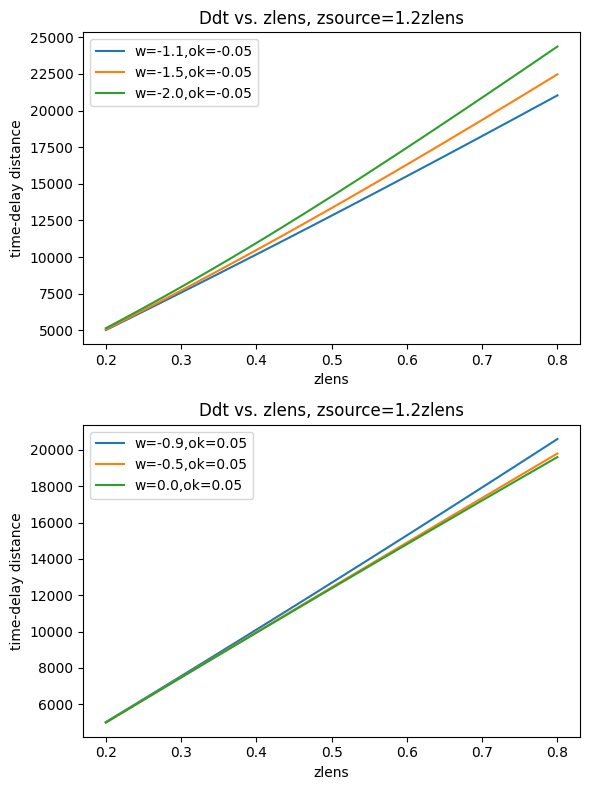

In [15]:
# task1 (delete when posting on github)

w_list1, w_list2 = [-1.1, -1.5, -2.0], [-0.9, -0.5, 0.0]
ok_list1, ok_list2 = [-0.05], [0.05]
zlens = np.linspace(0.2, 0.8, 100)
zsource = 1.2*zlens

fig, ax = plt.subplots(2,1,figsize=(6,4*2))
ax[0].set_xlabel('zlens')
ax[0].set_ylabel('time-delay distance')
ax[0].set_title('Ddt vs. zlens, zsource=1.2zlens')
ax[1].set_xlabel('zlens')
ax[1].set_ylabel('time-delay distance')
ax[1].set_title('Ddt vs. zlens, zsource=1.2zlens')

for w in w_list1:
    for ok in ok_list1:
        H0_mock, Om0_mock, Ok0_mock, w_mock, M_mock = 72, 0.3, ok, w, -19.2
        cosmo_mock = wCDM(H0=H0_mock, Om0=Om0_mock, Ode0=1.-Om0_mock-Ok0_mock, w0=w_mock)
        dd_mock = cosmo_mock.angular_diameter_distance(z=zlens)
        ds_mock = cosmo_mock.angular_diameter_distance(z=zsource)
        dds_mock = cosmo_mock.angular_diameter_distance_z1z2(z1=zlens, z2=zsource)
        ddt_mock = (1. + zlens) * dd_mock * ds_mock / dds_mock
        ax[0].plot(zlens, ddt_mock, label=f'w={w},ok={ok}')
ax[0].legend()

for w in w_list2:
    for ok in ok_list2:
        H0_mock, Om0_mock, Ok0_mock, w_mock, M_mock = 72, 0.3, ok, w, -19.2
        cosmo_mock = wCDM(H0=H0_mock, Om0=Om0_mock, Ode0=1.-Om0_mock-Ok0_mock, w0=w_mock)
        dd_mock = cosmo_mock.angular_diameter_distance(z=zlens)
        ds_mock = cosmo_mock.angular_diameter_distance(z=zsource)
        dds_mock = cosmo_mock.angular_diameter_distance_z1z2(z1=zlens, z2=zsource)
        ddt_mock = (1. + zlens) * dd_mock * ds_mock / dds_mock
        ax[1].plot(zlens, ddt_mock, label=f'w={w},ok={ok}')
ax[1].legend()

plt.tight_layout()
plt.show()